# Анализ данных с временной структурой и симуляционные модели 22/23

## Проект №1

* Букашкин Антон
* Смирнов Никита
* Зайцев Георгий 
*  Артем Обухов

### импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go 
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss


import sklearn.metrics as metrics

from pytrends.request import TrendReq

import datetime

from itertools import product
import warnings

from dateutil.relativedelta import relativedelta

import statsmodels

In [2]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

### посмотрим на сами данные

In [3]:
df = pd.read_csv('Project_dataset_1.csv')
df.head()

,Date,Total
0,1986-1-01,9034
1,1986-2-01,9596
2,1986-3-01,10558
3,1986-4-01,9002
4,1986-5-01,9239


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    312 non-null    object
 1   Total   312 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.0+ KB


In [5]:
# преобразуем в тип datetime
df['Date'] = pd.to_datetime(df['Date'])

In [24]:
#график для метода пристального взгляда

fig = go.Figure()

fig.add_trace(go.Scatter(y=df['Total'], x=df['Date'], name='time_series'))

fig.update_layout(
   title_text='Временной ряд', 
   xaxis_title_text='дата', 
   yaxis_title_text='таргет'
)

fig.show()

C:\python\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



* явно выраженные пики в марте (иногда в феврали) и просадки в декабре
* сначала тренд возрастающий, затем тренд становится убывающим
* где-то с 1998 по 2002 явно видна цикличность

### Проверка стационарности и STL-декомпозиция ряда:

In [7]:
df.index = df['Date']

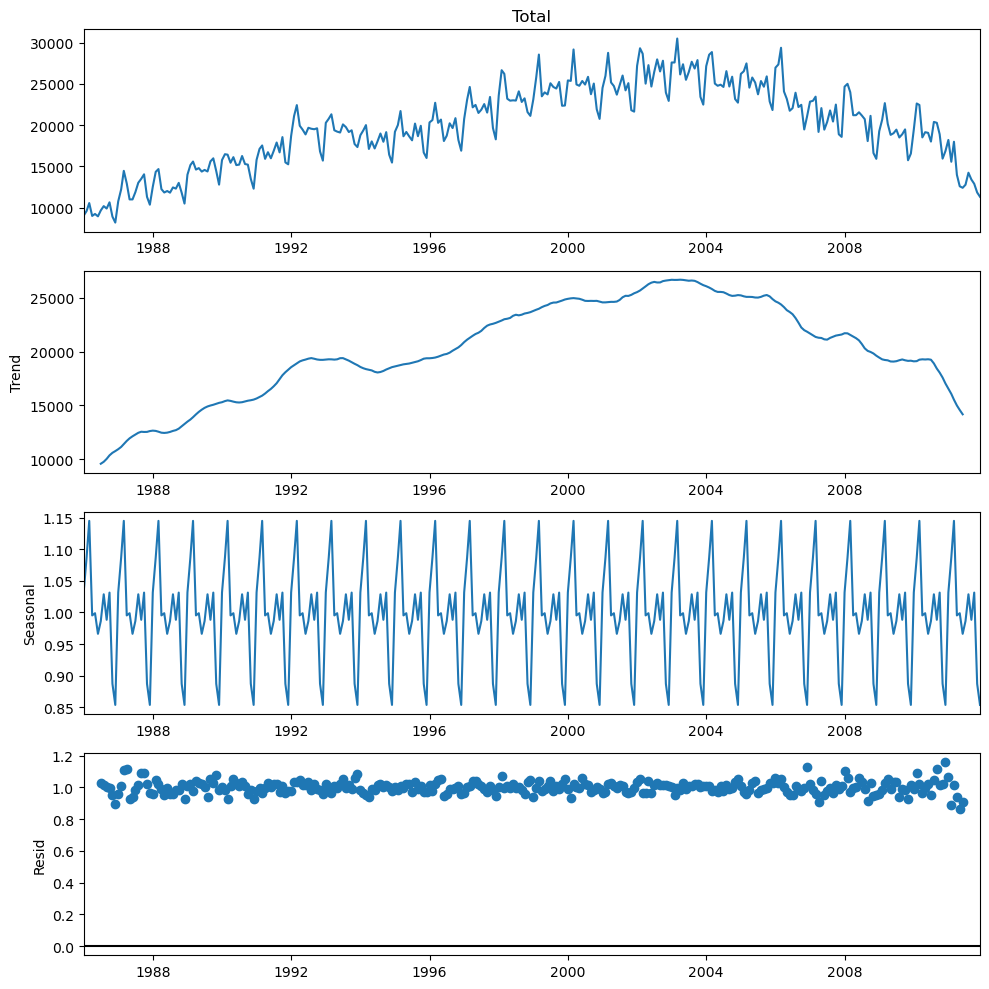

Критерий Дики-Фуллера: p_value = 0.755496


In [8]:
#мультипликативная модель декомпозиции
plt.rcParams.update({'figure.figsize': (10,10)})
sm.tsa.seasonal_decompose(df['Total'], model='multiplicative').plot()
plt.show()
print("Критерий Дики-Фуллера: p_value = %f" % sm.tsa.stattools.adfuller(df['Total'])[1])

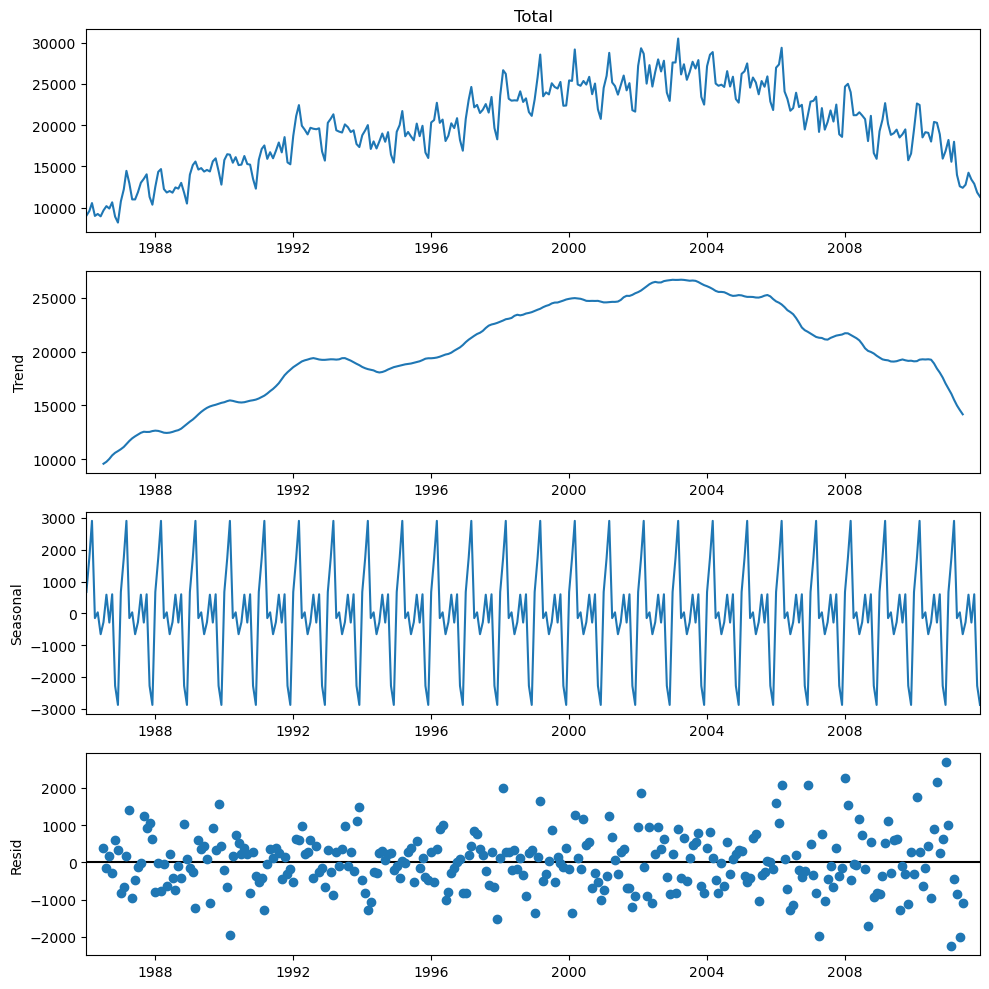

Критерий Дики-Фуллера: p_value = 0.755496


In [9]:
#аддитивная модель
plt.rcParams.update({'figure.figsize': (10,10)})
sm.tsa.seasonal_decompose(df['Total'], model='additive').plot()
plt.show()
print("Критерий Дики-Фуллера: p_value = %f" % sm.tsa.stattools.adfuller(df['Total'])[1])

***p_value для Критерия Дики-Фуллера ~0.75, следовательно нельзя отклонить гипотезу H0 о том, что временной ряд является нестационарным. Ряд не имеет постоянного матожидания, дисперсии и независимость ковариационной функции от времени.***

***Остатки для мультипликативной модели имеют некоторый паттерн поведения. Остатки аддитивной модели выглядят более случайными. Первая модель предпочтительнее.***

Попробуем сделать преобразование Бокса-Кокса:

Оптимальный параметр преобразования Бокса-Кокса: 1.308367
Критерий Дики-Фуллера: p = 0.734890


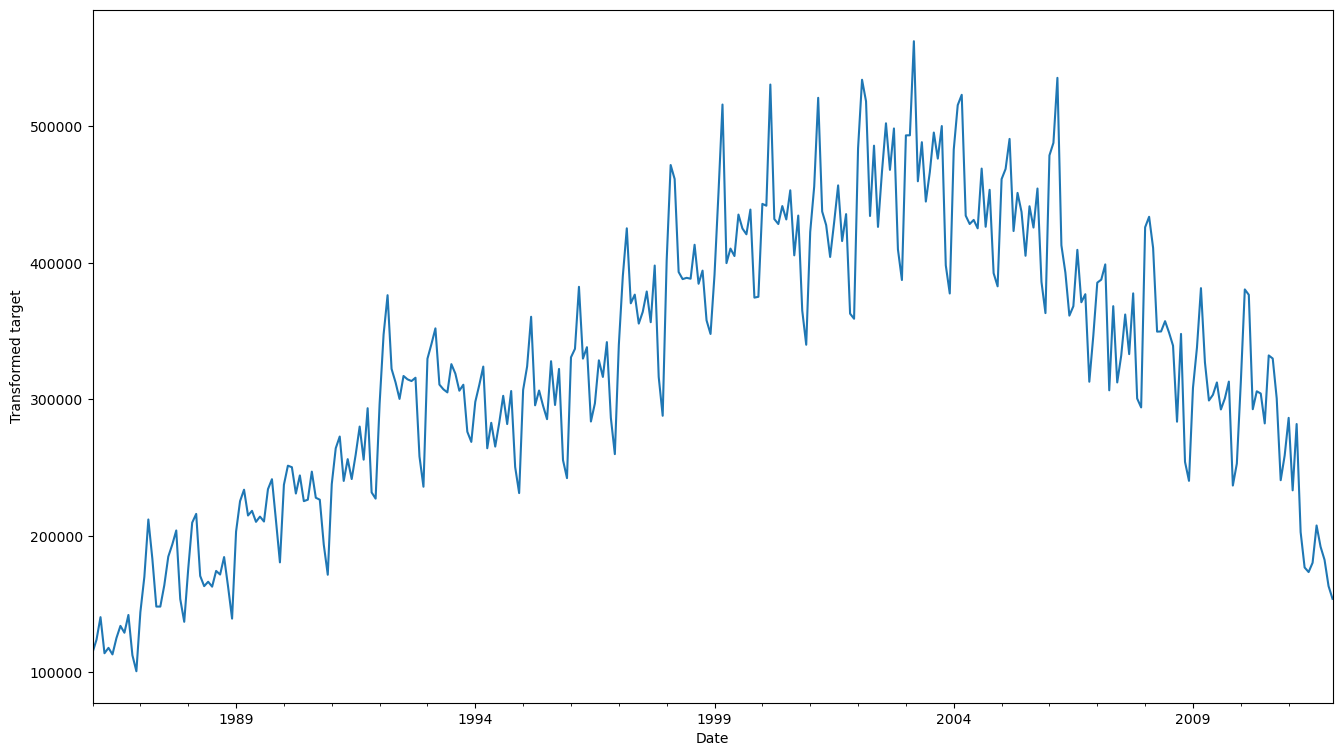

In [10]:
df['Total_box'], lmbda = stats.boxcox(df['Total'])
plt.rcParams.update({'figure.figsize': (16,9)})
df['Total_box'].plot()
plt.ylabel(u'Transformed target')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(df['Total_box'])[1])

Критерий Дики-Фуллера по-прежнему не отвергает гипотезу о нестационарности ряда

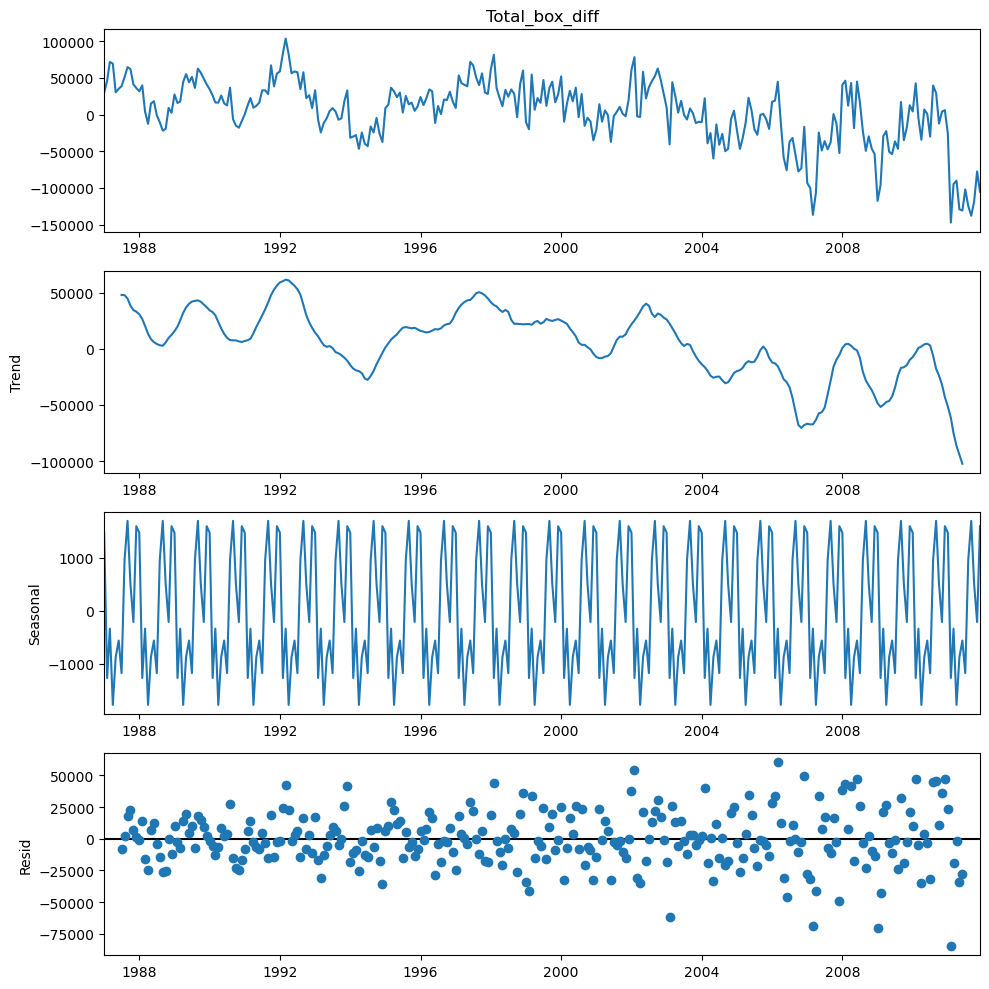

Критерий Дики-Фуллера: p=0.451930


In [11]:
df['Total_box_diff'] = df['Total_box'] - df['Total_box'].shift(12)
plt.rcParams.update({'figure.figsize': (10,10)})
sm.tsa.seasonal_decompose(df['Total_box_diff'][12:]).plot()
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Total_box_diff'][12:])[1])

In [12]:
print('P-value для теста KPSS = ', kpss(df['Total_box_diff'][12:])[1])

P-value для теста KPSS =  0.01


C:\python\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




KPSS тест отвергает гипотезу о нестационарности ряда

Стало намного лучше, но не удалось избавиться от тренда

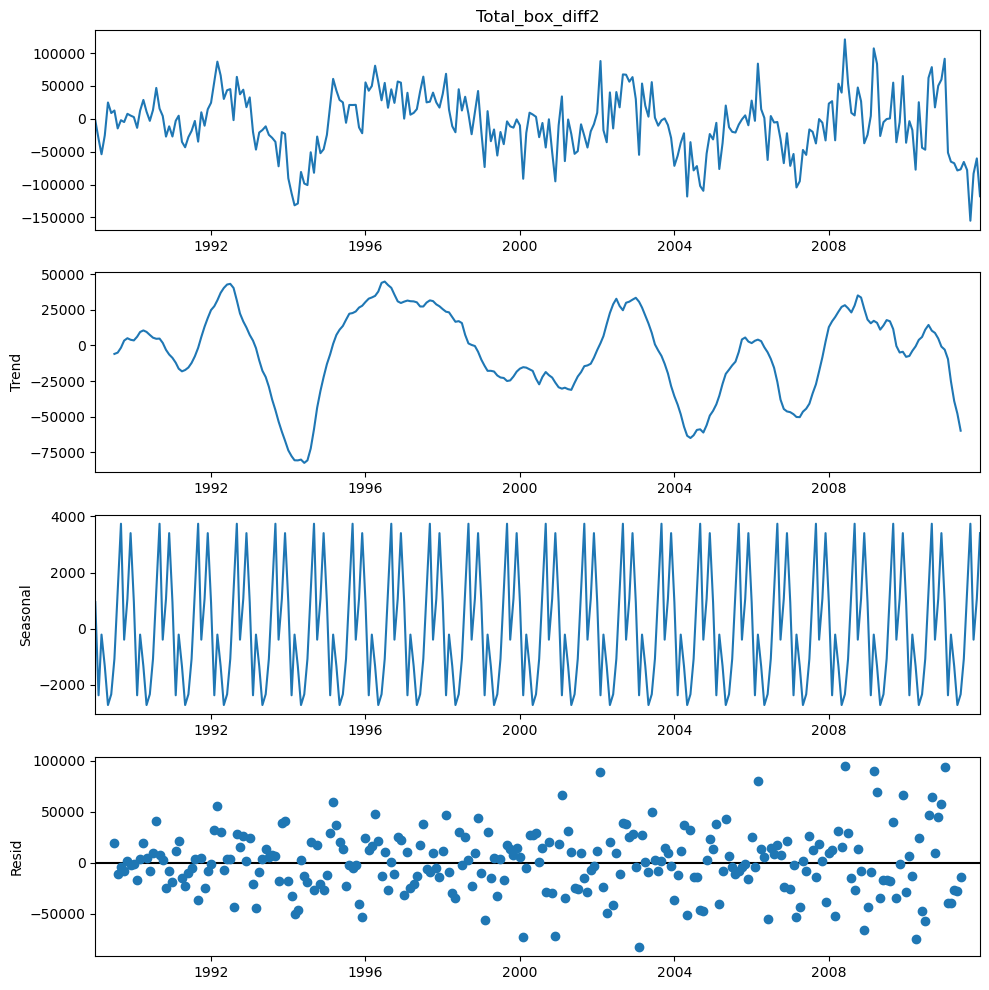

Критерий Дики-Фуллера: p=0.000281


In [13]:
df['Total_box_diff2'] = df['Total_box_diff'] - df['Total_box_diff'].shift(24)
plt.rcParams.update({'figure.figsize': (10,10)})
sm.tsa.seasonal_decompose(df['Total_box_diff2'][36:]).plot()
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Total_box_diff2'][36:])[1])

Гипотеза о нестационарности ряда отвергается после второго дифференцирования

In [14]:
print('P-value для теста KPSS = ', kpss(df['Total_box_diff2'][36:])[1])

P-value для теста KPSS =  0.1


C:\python\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




KPSS тест тоже не отвергает гипотезу о нестационарности ряда

После второго диффиренцирования нет смысла делать это больше

### ACF и PACF полученного ряда

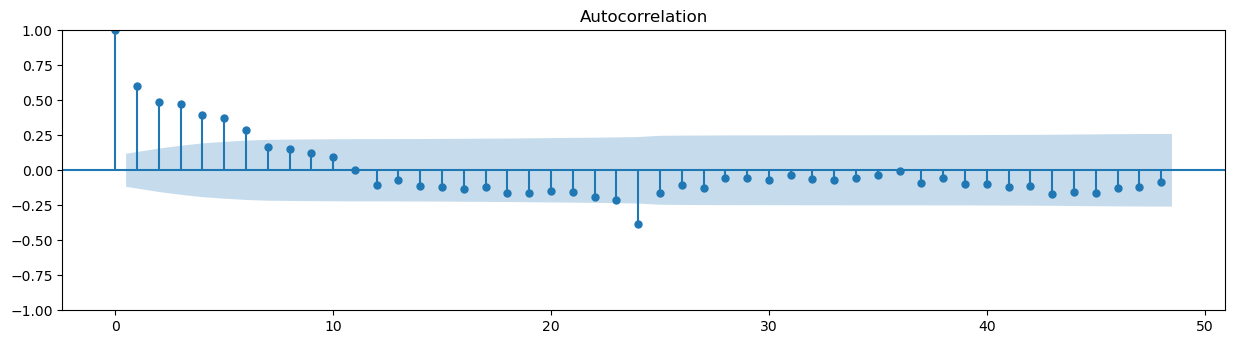

C:\python\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



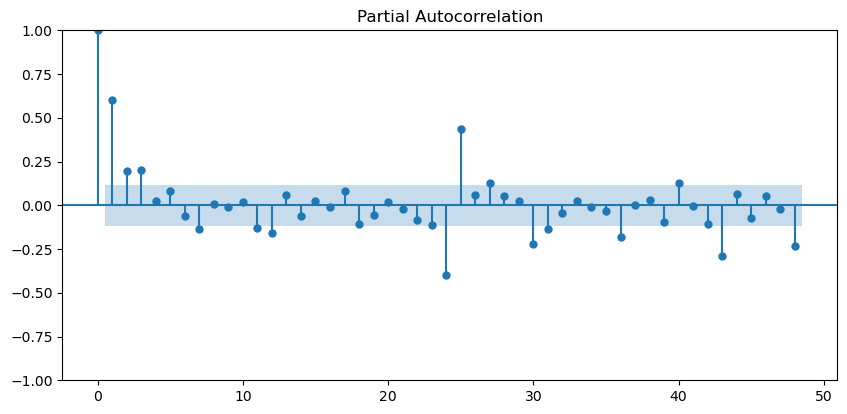

In [15]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['Total_box_diff2'][36:].values.squeeze(), lags=48, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['Total_box_diff2'][36:].values.squeeze(), lags=48, ax=ax)
plt.show()

начальные приближения по автокорреляционной и частично-автокорреляционной функции: `Q` = 2, `q` = 7 , `P` = 2 , `p` = 4

In [16]:
ps = range(0, 4) #порядок AR
d = 0 #обычное дифферинцирование
qs = range(0, 9) #порядок MA
Ps = range(0, 2) #авторегрессионный компонент
D = 2 #количество сезонных диффов
Qs = range(0, 2)#компонент скользящего среднего

In [17]:
# для подбора гиперпарамметров
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

### подбор параметров по информационному критерию акаике

In [18]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df['Total_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 7min 49s


### информация о модели

In [19]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters          aic
127  (3, 4, 1, 1)  6779.040410
87   (2, 3, 1, 1)  6786.511189
123  (3, 3, 1, 1)  6788.415521
119  (3, 2, 1, 1)  6788.724083
131  (3, 5, 1, 1)  6788.733314


In [20]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            Total_box   No. Observations:                  312
Model:             SARIMAX(3, 0, 4)x(1, 2, [1], 12)   Log Likelihood               -3379.520
Date:                              Sat, 25 Feb 2023   AIC                           6779.040
Time:                                      21:39:04   BIC                           6815.670
Sample:                                  01-01-1986   HQIC                          6793.719
                                       - 12-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4865      1.515      0.321      0.748      -2.483       3.456
ar.L2          0.84

### посмотрим на остатки модели

Критерий Стьюдента: p = 0.038664
Критерий Дики-Фуллера: p = 0.000000
Критерий Дики-Фуллера: p = 0.062228


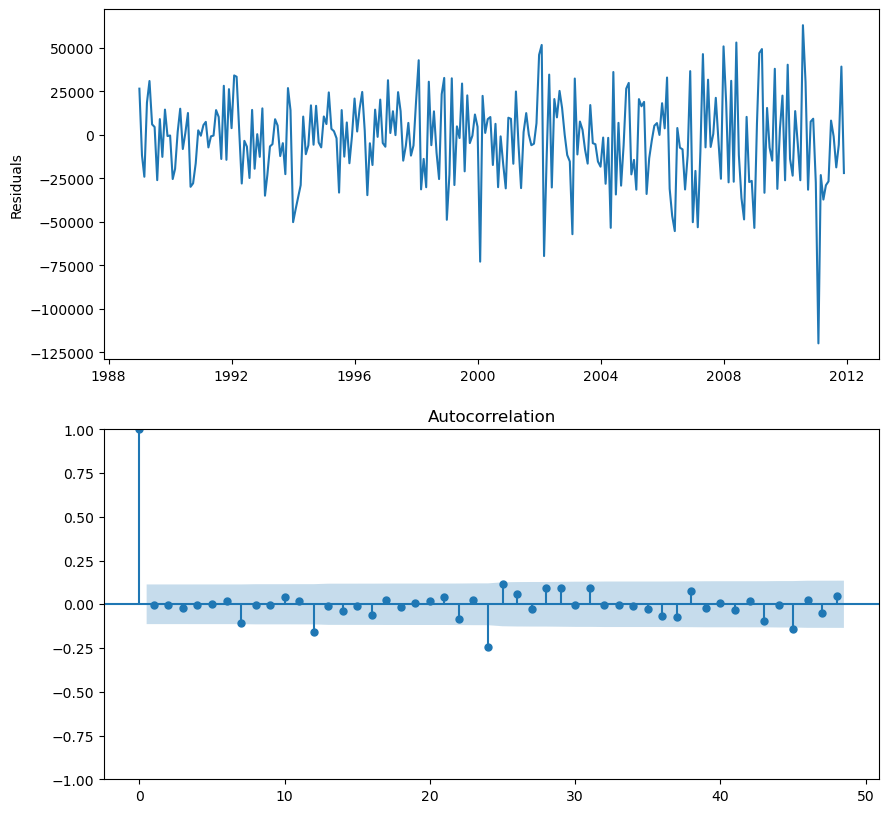

In [21]:
plt.subplot(211)
plt.plot(best_model.resid[36:])
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p = %f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])
print("Критерий Дики-Фуллера: p = %f" % statsmodels.stats.diagnostic.acorr_ljungbox(best_model.resid[13:].values, lags=[36+24]).iloc[0,1])

* Остатки несмещены,подтверждается критерием Стьюдента, p-val==0. 
* Cтационарны (подтверждается критерием Дики-Фуллера, p-val==0.4). 
* Неавтокоррелированы (подтверждается критерием Льюнга-Бокса, p-val==0.598435)

### прогноз

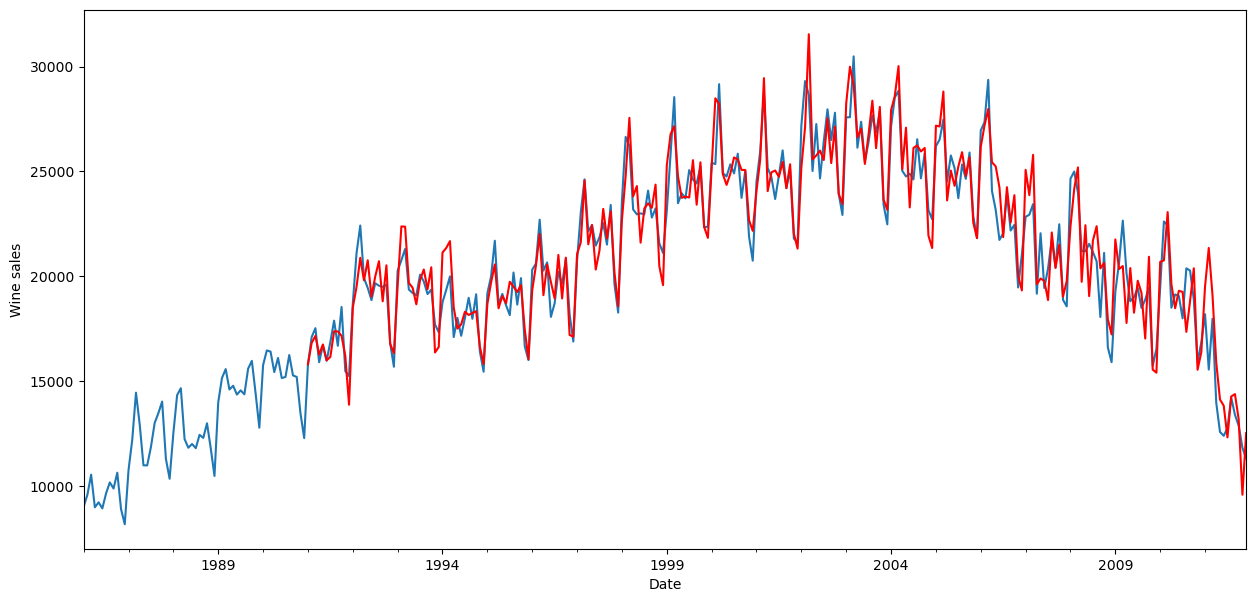

In [22]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
df['Total'].plot()
df.model[36+24:].plot(color='r')
plt.ylabel('Wine sales')
plt.show()

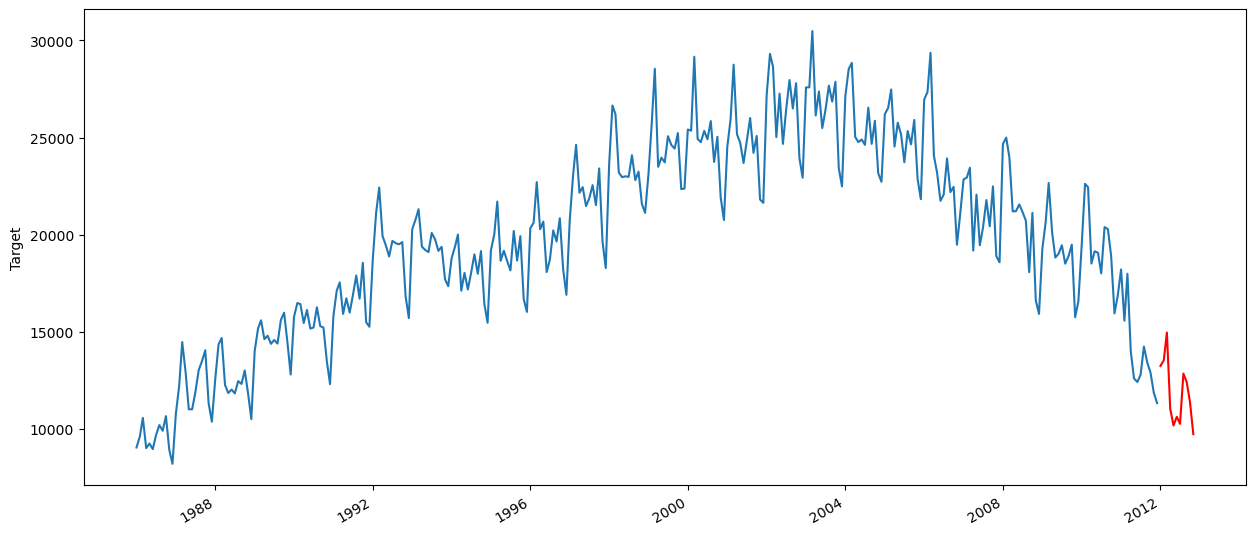

In [23]:
df2 = df[['Total']]
date_list = [datetime.datetime.strptime("2011-12-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=312, end=324), lmbda)

plt.figure(figsize=(15,7))
df2['Total'].plot()
df2.forecast.plot(color='r')
plt.ylabel('Target')
plt.show()